The goal for this notebook is to prepare the training examples and have everything ready for training the thermal YOLO model

In [141]:
import tensorflow as tf
import numpy as np
import cv2 as cv

In [142]:
def conv_block(x, filters, kernel_size=3, stride=1):
    x = tf.keras.layers.Conv2D(filters=filters, padding='same', activation='relu', kernel_size=(3,3))(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
    return x



In [143]:
yolo_input = tf.keras.layers.Input(shape=(512, 640,3))

x = yolo_input

for i in range(4):
    x = conv_block(x, 16* (2**i), 3, 1)


In [144]:
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(x)
print(x.shape)

(None, 32, 40, 256)


In [145]:
branch0 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
branch0 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(branch0)

In [146]:
#branch0 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(1,1))(branch0)
branch0 = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), activation='relu', padding='same')(branch0)
print(branch0.shape)

(None, 16, 20, 1024)


In [147]:
branch0 = tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), activation='relu', padding='valid')(branch0)

In [148]:
# first concatonate back with x
branch01 = tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu', padding='valid')(branch0)
branch01 = tf.keras.layers.UpSampling2D(size=(2,2))(branch01)
print(branch01.shape)
yolo_1_01 = tf.keras.layers.Concatenate(axis=-1)([x, branch01])
yolo_1_01 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same')(yolo_1_01)
yolo_1_01 = tf.keras.layers.LeakyReLU()(yolo_1_01)
yolo_1_01 = tf.keras.layers.Conv2D(filters=21, kernel_size=(1,1), padding='valid')(yolo_1_01)
yolo_1_01 = tf.keras.layers.LeakyReLU()(yolo_1_01)
yolo_1_01 = tf.keras.layers.Activation('sigmoid', name='yolo_far')(yolo_1_01)

(None, 32, 40, 128)


In [149]:
yolo_00 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same')(branch0)
yolo_00 = tf.keras.layers.LeakyReLU()(yolo_00)
yolo_00 = tf.keras.layers.Conv2D(filters=21, kernel_size=(1,1), padding='valid')(yolo_00)
yolo_00 = tf.keras.layers.LeakyReLU()(yolo_00)
yolo_00 = tf.keras.layers.Activation('sigmoid', name='yolo_close')(yolo_00)

In [150]:
model = tf.keras.models.Model(inputs=yolo_input, outputs=[yolo_00, yolo_1_01])

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 512, 640, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_35 (MaxPooling2D) (None, 256, 320, 16) 0           conv2d_91[0][0]                  
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 256, 320, 32) 4640        max_pooling2d_35[0][0]           
____________________________________________________________________________________________

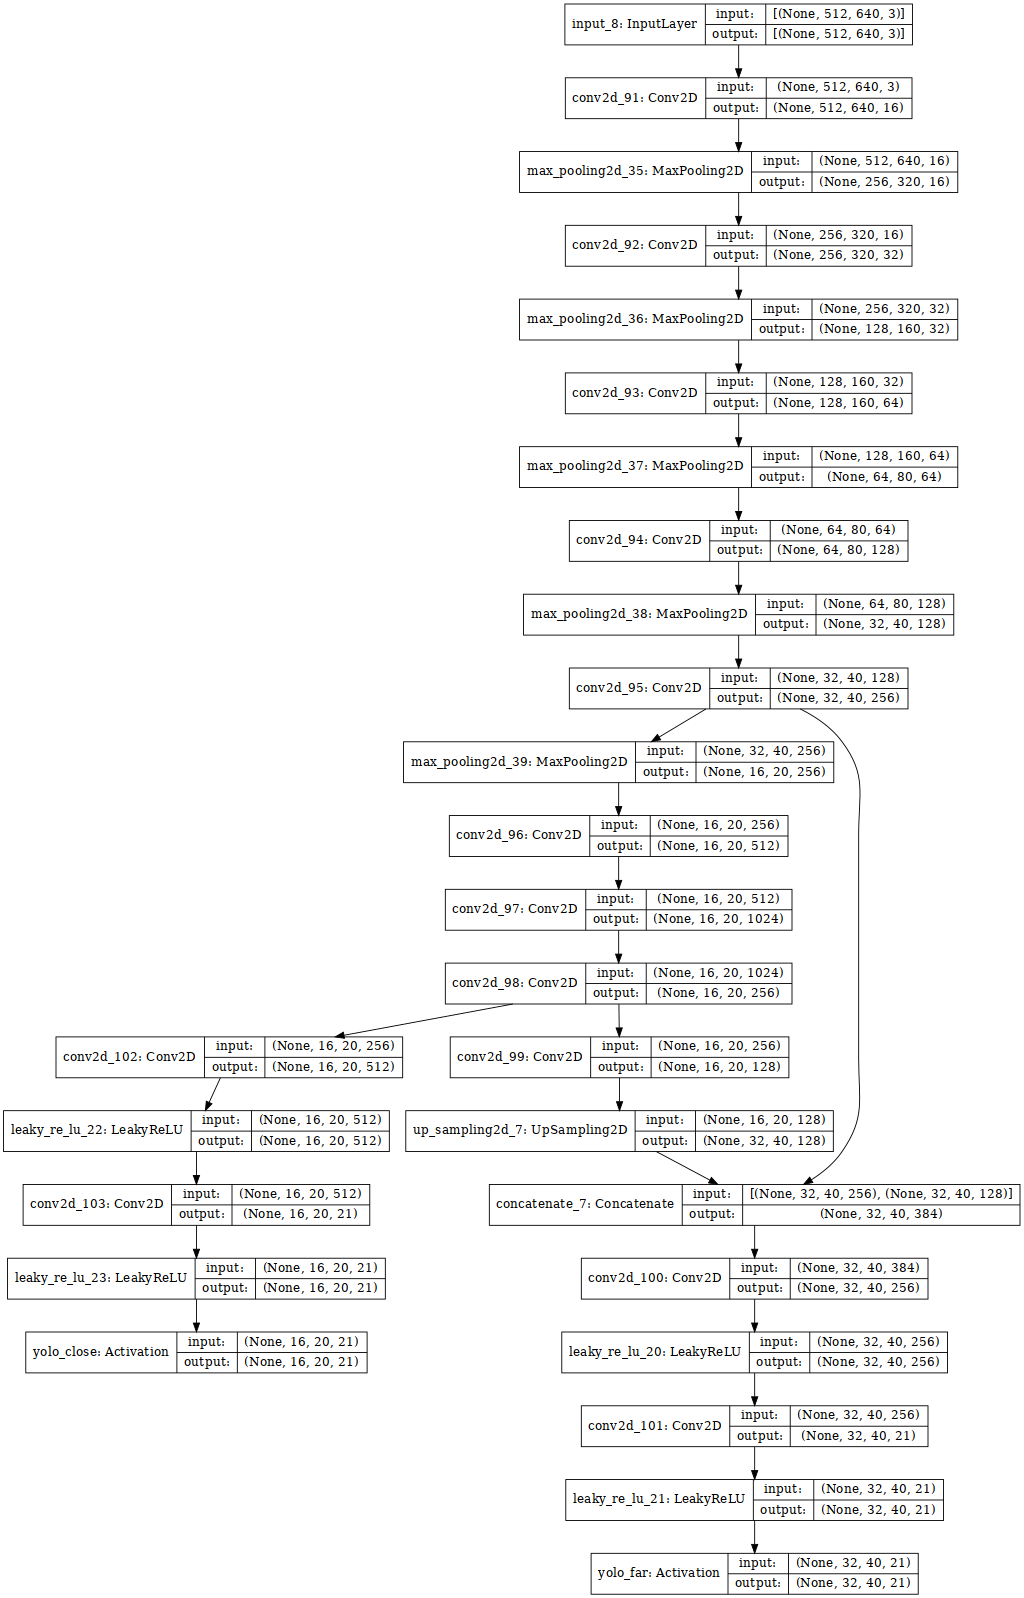

In [151]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [1]:
def loss_fn(y_true, y_pred):

    position_loss = 0
    box_size_loss = 0
    prob_obj_loss = 0
    prob_noobj_loss = 0
    prob_human_loss = 0
    lambda_coord = 5
    lambda_noobj = 0.5
    
    y_true_0 = y_true
    y_pred_0 = y_pred
    y_pred_0 = 1 + (127.5*y_pred)
    shape0 = np.array(y_pred_0).shape

    for row in range(shape0[1]):
        for col in range(shape0[2]):
            for channel in range(3):
                y_true_0_x = y_true_0[0][row][col][channel*7 + 0]
                y_true_0_y = y_true_0[0][row][col][channel*7 + 1]
                y_true_0_w = y_true_0[0][row][col][channel*7 + 2]
                y_true_0_h = y_true_0[0][row][col][channel*7 + 3]
                y_true_0_probObj = y_true_0[0][row][col][channel*7 + 4]
                y_true_0_probHumanGivenObject = y_true_0[0][row][col][channel*7 + 5]
                
                y_pred_0_x = y_pred_0[0][row][col][channel*7 + 0]
                y_pred_0_y = y_pred_0[0][row][col][channel*7 + 1]
                y_pred_0_w = y_pred_0[0][row][col][channel*7 + 2]
                y_pred_0_h = y_pred_0[0][row][col][channel*7 + 3]
                y_pred_0_probObj = y_pred_0[0][row][col][channel*7 + 4]
                y_pred_0_probHumanGivenObject = y_pred_0[0][row][col][channel*7 + 5]

         
                prob_obj_loss += tf.math.squared_difference(y_true_0_probObj, y_pred_0_probObj)
                #print(prob_obj_loss)
                position_loss += tf.math.squared_difference(y_true_0_x, y_pred_0_x) + tf.math.squared_difference(y_true_0_y, y_pred_0_y)
                box_size_loss += tf.math.squared_difference(tf.math.sqrt(y_true_0_w), tf.sqrt(y_pred_0_w)) + tf.math.squared_difference(tf.math.sqrt(y_true_0_h), tf.math.sqrt(y_pred_0_h))
                prob_human_loss += tf.math.squared_difference(y_true_0_probHumanGivenObject, y_pred_0_probHumanGivenObject)
        
    return lambda_coord * (position_loss + box_size_loss) + prob_obj_loss + lambda_noobj*prob_noobj_loss + prob_human_loss


In [153]:
def preprocess(im):
    im = np.array(im, dtype='f')
    im = (im-127.5)/127.5
    im = tf.convert_to_tensor(im)
    im = tf.expand_dims(im, axis=0)
    return im

In [154]:
directory = "Images/YOLO_pre_generator/train_images/"
labeled = []
for x in range(500):
    try:
        f = open(directory+"train_" + str(x) + ".txt", 'r')
        lines = f.readlines()
        lines = [[float(n) for n in line.split()] for line in lines]
        if len(lines) > 0: # if its a image with labeled objects in it
            labeled.append((x, lines)) # append the image number, bbox info
        f.close()
    except:
        pass
    

In [155]:
labeled

[(131,
  [[0.0, 0.533445, 0.686848, 0.010033, 0.05428],
   [0.0, 0.559643, 0.689979, 0.015608, 0.035491],
   [0.0, 0.570234, 0.709812, 0.018952, 0.041754]]),
 (132,
  [[1.0, 0.536232, 0.676409, 0.020067, 0.05428],
   [0.0, 0.533445, 0.679541, 0.012263, 0.043841],
   [0.0, 0.557971, 0.683716, 0.010033, 0.060543],
   [0.0, 0.580268, 0.701461, 0.018952, 0.050104]]),
 (133,
  [[0.0, 0.529543, 0.68476, 0.024526, 0.041754],
   [0.0, 0.554627, 0.678497, 0.016722, 0.05428],
   [0.0, 0.595875, 0.704593, 0.023411, 0.052192]]),
 (134,
  [[0.0, 0.530658, 0.688935, 0.020067, 0.05428],
   [0.0, 0.555741, 0.685804, 0.025641, 0.056367],
   [0.0, 0.618729, 0.720251, 0.031215, 0.045929]]),
 (135,
  [[0.0, 0.537347, 0.69833, 0.020067, 0.048017],
   [0.0, 0.566332, 0.689979, 0.031215, 0.064718],
   [0.0, 0.64214, 0.726514, 0.026756, 0.058455]]),
 (136,
  [[0.0, 0.549052, 0.707724, 0.027871, 0.066806],
   [0.0, 0.580825, 0.710856, 0.022297, 0.043841],
   [0.0, 0.688406, 0.754697, 0.023411, 0.035491]]),
 (1

In [156]:

y_train = []
y_train_00 = []
y_train_1_01 = []
z0_block_dims = 32.0
o_zo_block_dims = 16.0

for labeled_img in labeled:
    labels = labeled_img[1]
    arr00 = [[[0.0, 0.0, 0.0, 0.0, 0, 0, 0]*3 for col in range(20)] for row in range(16)]
    arr_1_01 = [[[0,0,0,0,0,0,0]*3 for col in range(40)] for row in range(32)]
    for label in labels:
        lst = label
        clss = lst[0]
        x = lst[1]
        y = lst[2]
        w = lst[3]
        h = lst[4]
        grid_row_1_01 = int(y*32)
        grid_row_00 = int(y*16)
        grid_col_1_01 = int(x*40)
        grid_col_00 = int(x*20)
        for i in range(3):
            arr00[grid_row_00][grid_col_00][7*i + 0] = (x*640.0 - 32.0*grid_col_00)/32.0
            arr00[grid_row_00][grid_col_00][7*i + 1] = (y*512.0 - 32.0*grid_row_00)/32.0
            arr00[grid_row_00][grid_col_00][7*i + 2] = w
            arr00[grid_row_00][grid_col_00][7*i + 3] = h
            arr00[grid_row_00][grid_col_00][7*i + 4] = 1.0
            arr00[grid_row_00][grid_col_00][7*i + 5] = 1.0
            
            arr_1_01[grid_row_1_01][grid_col_1_01][7*i + 0] = (x*640.0 - 16*grid_col_1_01)/16.0
            arr_1_01[grid_row_1_01][grid_col_1_01][7*i + 1] = (y*512.0 - 16*grid_row_1_01)/16.0
            arr_1_01[grid_row_1_01][grid_col_1_01][7*i + 2] = w
            arr_1_01[grid_row_1_01][grid_col_1_01][7*i + 3] = h
            arr_1_01[grid_row_1_01][grid_col_1_01][7*i + 4] = 1.0
            arr_1_01[grid_row_1_01][grid_col_1_01][7*i + 5] = 1.0

    y_train_00.append(preprocess(arr00))
    y_train_1_01.append(preprocess(arr_1_01))
    
        # post processing will entail that output width = pixels_in_image*w

In [157]:
x_train = []
for label in labeled:
    idx = label[0]
    mat = cv.imread(directory+"train_" + str(idx) + ".jpg", cv.IMREAD_COLOR)
    mat = cv.cvtColor(mat, cv.COLOR_BGR2RGB)
    x_train.append(preprocess(mat))

In [129]:
len(y_train_00)


74

In [130]:
len(x_train)

74

In [131]:
model

In [132]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

In [133]:
y_train = np.array(y_train_00), np.array(y_train_1_01)
x_train = np.array(x_train)
x_train.shape

(74, 1, 512, 640, 3)

In [134]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [135]:
print(np.array(x_train).shape)
print(np.array(y_train_00).shape)
print(np.array(y_train_1_01).shape)
x_train[0]

(74, 1, 512, 640, 3)
(74, 1, 16, 20, 21)
(74, 1, 32, 40, 21)


array([[[[-0.85882354, -0.8352941 , -0.43529412],
         [-0.85882354, -0.8352941 , -0.43529412],
         [-0.85882354, -0.8352941 , -0.43529412],
         ...,
         [-0.8666667 , -0.8352941 , -0.48235294],
         [-0.8666667 , -0.827451  , -0.49803922],
         [-0.8666667 , -0.827451  , -0.49803922]],

        [[-0.85882354, -0.8352941 , -0.43529412],
         [-0.85882354, -0.8352941 , -0.43529412],
         [-0.85882354, -0.8352941 , -0.43529412],
         ...,
         [-0.8666667 , -0.8352941 , -0.48235294],
         [-0.8666667 , -0.827451  , -0.49803922],
         [-0.8666667 , -0.827451  , -0.5137255 ]],

        [[-0.8666667 , -0.84313726, -0.42745098],
         [-0.8666667 , -0.84313726, -0.42745098],
         [-0.8666667 , -0.84313726, -0.42745098],
         ...,
         [-0.8666667 , -0.8352941 , -0.48235294],
         [-0.8666667 , -0.827451  , -0.49803922],
         [-0.8666667 , -0.827451  , -0.5294118 ]],

        ...,

        [[ 0.01960784, -0.88235295,  0

In [136]:
num_epochs = 10
batch_size = 5

In [137]:
import random

In [138]:
model.compile(optimizer='adam', loss=[loss_fn, loss_fn])

In [139]:
model(x_train[1])

[<tf.Tensor: shape=(1, 16, 20, 21), dtype=float32, numpy=
 array([[[[0.49463886, 0.7613227 , 0.47532597, ..., 0.55368507,
           0.48344287, 0.5350033 ],
          [0.48335898, 0.60529983, 0.4510052 , ..., 0.4411182 ,
           0.48435903, 0.5175093 ],
          [0.4751051 , 0.6377225 , 0.48399794, ..., 0.44694504,
           0.4744752 , 0.5522481 ],
          ...,
          [0.46222648, 0.51674813, 0.5544096 , ..., 0.4814905 ,
           0.45399672, 0.483593  ],
          [0.4659381 , 0.5400397 , 0.47502407, ..., 0.44276622,
           0.46243227, 0.4998674 ],
          [0.4944821 , 0.6981737 , 0.61110616, ..., 0.4717212 ,
           0.47038737, 0.5763741 ]],
 
         [[0.45238844, 0.51420546, 0.56446385, ..., 0.45442566,
           0.4649158 , 0.642895  ],
          [0.48504215, 0.60856205, 0.47681737, ..., 0.48688036,
           0.48601988, 0.5243347 ],
          [0.5032039 , 0.62849927, 0.49975526, ..., 0.4184064 ,
           0.45312768, 0.5129869 ],
          ...,
         

In [140]:
for epoch in range(num_epochs):
    epoch_loss_00 = 0.0
    epoch_loss_1_01 = 0.0
    
    for j in range(batch_size):
        rand_idx = random.randint(0, len(x_train)-1)
        x_input = x_train[rand_idx]
        
        with tf.GradientTape() as yolo_00_tape:
            out_00 = model(x_input)[0]
            print(out_00)
            loss_00 = loss_fn(y_train_00[rand_idx], out_00)
        
        with tf.GradientTape() as yolo_1_01_tape:
            out_1_01 = model(x_input)[1]
            loss_1_01 = loss_fn(y_train_1_01[rand_idx], out_1_01)
        
        grad_00 = yolo_00_tape.gradient(loss_00, model.trainable_variables)
        grad_1_01 = yolo_1_01_tape.gradient(loss_1_01, model.trainable_variables)
        
        optimizer.apply_gradients(zip(grad_00, model.trainable_variables))
        optimizer.apply_gradients(zip(grad_1_01, model.trainable_variables))
        
        epoch_loss_00 += loss_00
        epoch_loss_1_01 += loss_1_01
        
    print('Epoch ', str(epoch), 'Loss: ', epoch_loss_00 + epoch_loss_1_01)


tf.Tensor(
[[[[0.5075713  0.5253049  0.52196836 ... 0.51196915 0.52524084
    0.51829875]
   [0.5075713  0.5253049  0.52196836 ... 0.51196915 0.52524084
    0.51829875]
   [0.509633   0.5389263  0.52624965 ... 0.5225614  0.4953801
    0.50655985]
   ...
   [0.512427   0.5505543  0.49619058 ... 0.5250604  0.52733666
    0.51449436]
   [0.5100274  0.5524583  0.49892846 ... 0.5272523  0.5206157
    0.52124953]
   [0.5100274  0.5524583  0.49892846 ... 0.5272523  0.5206157
    0.52124953]]

  [[0.5283758  0.5271711  0.50811905 ... 0.5066737  0.49944866
    0.5213602 ]
   [0.5283758  0.5271711  0.50811905 ... 0.5066737  0.49944866
    0.5213602 ]
   [0.5421236  0.5220383  0.50149685 ... 0.51424843 0.50493014
    0.52676105]
   ...
   [0.50421786 0.53764796 0.49251643 ... 0.566535   0.52087635
    0.50709534]
   [0.5010906  0.5278067  0.49352464 ... 0.5552369  0.52366775
    0.5297344 ]
   [0.5010906  0.5278067  0.49352464 ... 0.5552369  0.52366775
    0.5297344 ]]

  [[0.5075713  0.5253049  

KeyboardInterrupt: 